## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3479,2023-01-10 00:00:00-03:00,104.849998,107.540001,104.720001,107.180000,4789116,0,0
3480,2023-01-11 00:00:00-03:00,107.400002,109.099998,107.110001,109.099998,6164690,0,0
3481,2023-01-12 00:00:00-03:00,108.500000,109.180000,106.940002,108.260002,5880623,0,0
3482,2023-01-13 00:00:00-03:00,106.940002,107.639999,106.690002,107.349998,4742049,0,0


In [4]:
len(bova11)

3484

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3386,2023-01-10 00:00:00-03:00,104.849998,107.540001,104.720001,107.180000,4789116,0,0
3387,2023-01-11 00:00:00-03:00,107.400002,109.099998,107.110001,109.099998,6164690,0,0
3388,2023-01-12 00:00:00-03:00,108.500000,109.180000,106.940002,108.260002,5880623,0,0
3389,2023-01-13 00:00:00-03:00,106.940002,107.639999,106.690002,107.349998,4742049,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3391/3391 [00:00<00:00, 18954.85it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

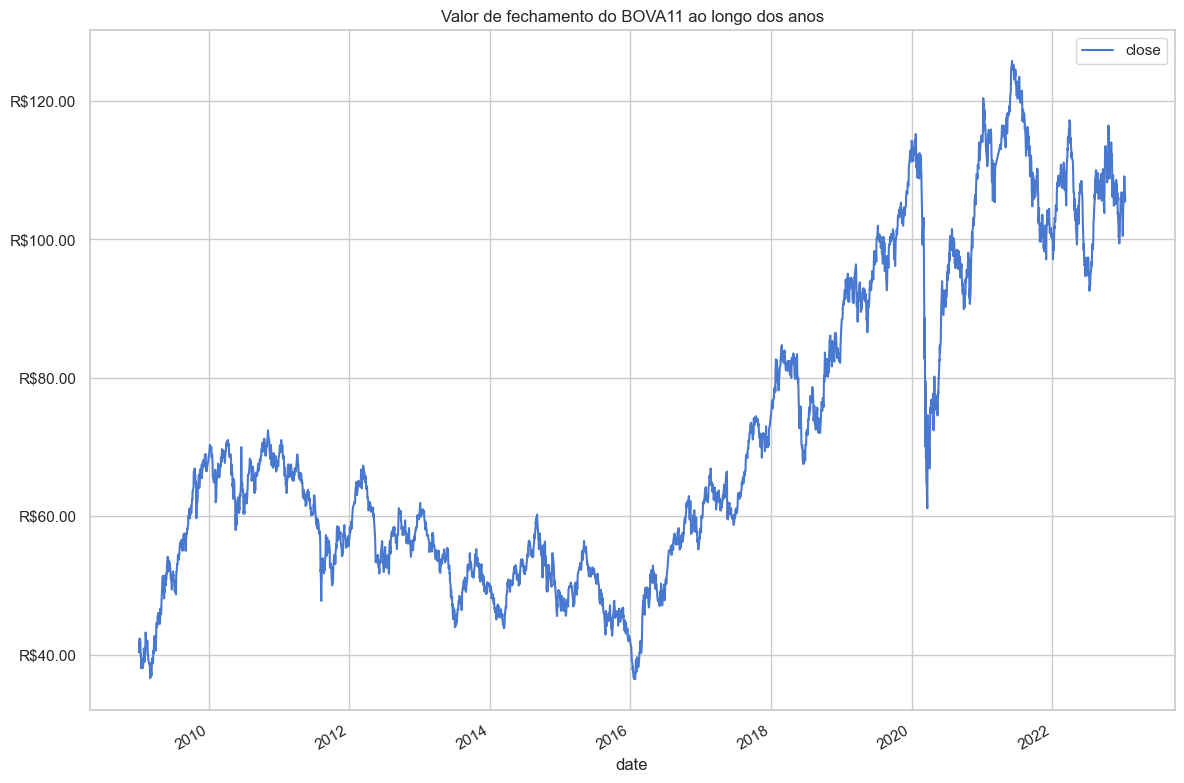

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

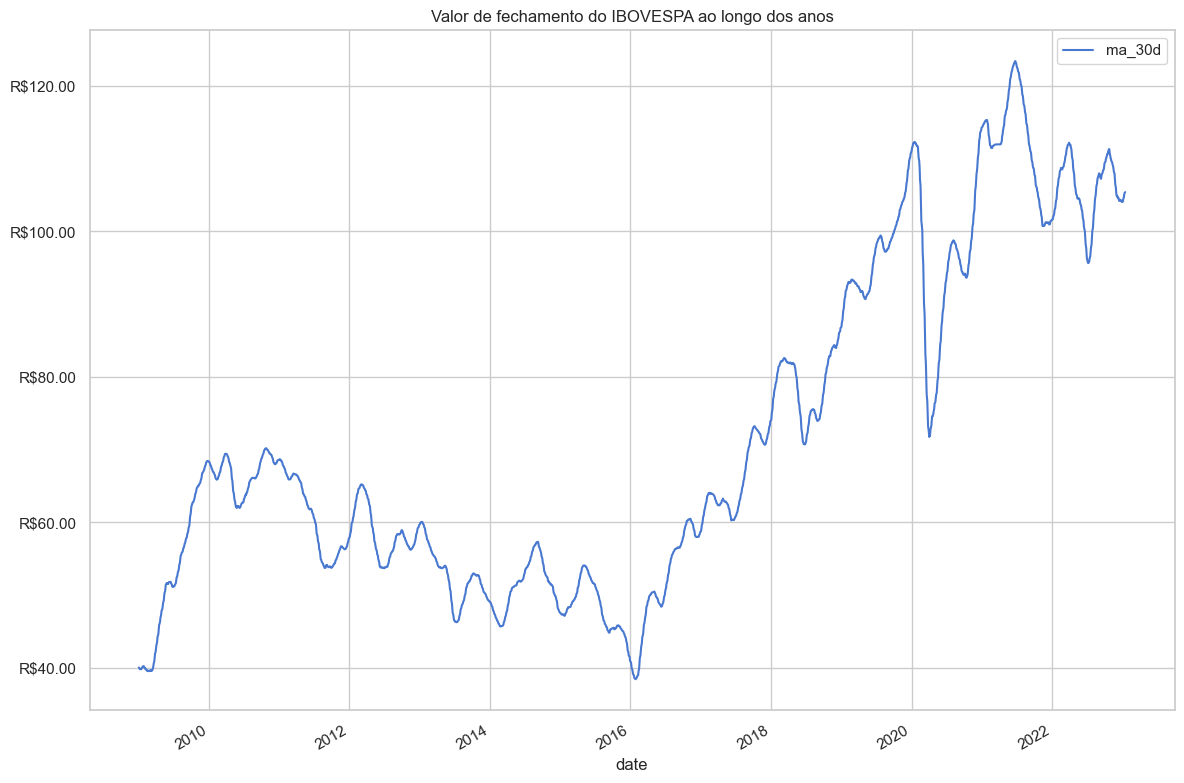

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,104.849998,107.540001,104.720001,107.180000,1.830002,107.209999,105.488000,104.951500,104.662571,1.732637,2.261830,2.622023,110.960359,103.459639,109.475160,100.427840,109.906618,99.418525,56.198950
3387,107.400002,109.099998,107.110001,109.099998,1.919998,108.180000,106.044444,105.140000,104.648235,1.493137,2.156378,2.660061,110.104992,106.255008,109.452756,100.827244,109.968358,99.328112,60.059868
3388,108.500000,109.180000,106.940002,108.260002,-0.839996,108.236666,106.559999,105.228333,104.568182,1.492105,2.183236,2.659389,109.987133,106.486200,109.594806,100.861861,109.886960,99.249404,57.676745
3389,106.940002,107.639999,106.690002,107.349998,-0.910004,107.026667,106.887143,105.308235,104.442812,1.358259,2.223135,2.600977,109.872319,104.181015,109.754505,100.861966,109.644766,99.240858,55.137312


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,104.849998,107.540001,104.720001,107.180000,1.830002,107.209999,105.488000,104.951500,104.662571,1.732637,...,2.622023,110.960359,103.459639,109.475160,100.427840,109.906618,99.418525,56.198950,2.330002,109.099998
3387,107.400002,109.099998,107.110001,109.099998,1.919998,108.180000,106.044444,105.140000,104.648235,1.493137,...,2.660061,110.104992,106.255008,109.452756,100.827244,109.968358,99.328112,60.059868,1.699997,108.260002
3388,108.500000,109.180000,106.940002,108.260002,-0.839996,108.236666,106.559999,105.228333,104.568182,1.492105,...,2.659389,109.987133,106.486200,109.594806,100.861861,109.886960,99.249404,57.676745,-0.239998,107.349998
3389,106.940002,107.639999,106.690002,107.349998,-0.910004,107.026667,106.887143,105.308235,104.442812,1.358259,...,2.600977,109.872319,104.181015,109.754505,100.861966,109.644766,99.240858,55.137312,0.409996,105.470001


In [24]:
bova11.dropna(inplace = True)

In [25]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.71059969  0.61789973  0.60440552 ...  0.34935422 -0.7951791
   0.60828672]
 [ 0.72811978  0.61968529  0.60058447 ...  0.27777661 -0.84924054
   0.5879059 ]
 [ 0.70327312  0.5853141   0.59496523 ...  0.20150421 -0.83112729
   0.5458007 ]]


Select the features and prediction target columns

In [26]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3275, 100, 19), (3275, 1))

Split the train and test data

In [27]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2947, 100, 19) (327, 100, 19) (2947, 1) (327, 1)


### 4. Creating the model

In [ ]:
def create_lstm_model(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(64, input_shape = (backcandles, num_features)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1), activation = 'linear')
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [ ]:
model = create_lstm_model(100, 19, 0.1)
model.fit(x = X_train, y = y_train, batch_size = 16, epochs = 10, shuffle = True, validation_split = 0.1)

In [ ]:
results = model.evaluate(X_test, y_test)

### 5. Making predictions

In [64]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 0s 19ms/step
[0.59091806] [0.62553188]
[0.60106575] [0.6223964]
[0.5926765] [0.55386342]
[0.58855057] [0.57625984]
[0.56148905] [0.56864497]
[0.56674904] [0.6134378]
[0.5627407] [0.56170213]
[0.5774397] [0.5603584]
[0.55593437] [0.5659575]
[0.5531292] [0.56707722]


In [65]:
y_pred.shape

(327, 1)

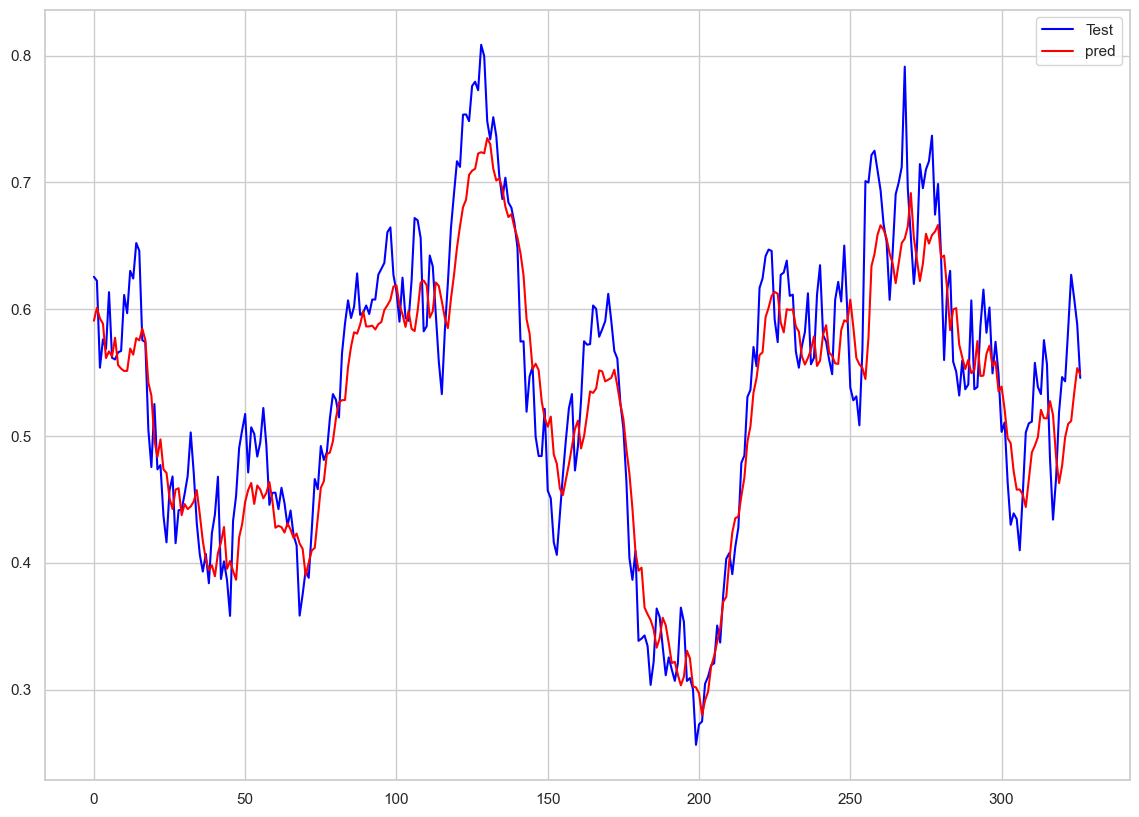

In [66]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [67]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [68]:
MAPE(y_test, y_pred)

6.571460299981992

In [69]:
MAE(y_test, y_pred)

0.03537042962389909

In [70]:
RMSE(y_test, y_pred)

0.04341630269878415

### 7. Tuning the hyperparameters

In [71]:
def LSTM_hyperparameter_tuning(config, x_train, y_train, x_test, y_test):
    first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout = config
    combinations = list(itertools.product(first_add_layer, second_add_layer, third_add_layer,
                                         n_neurons, n_batch_size, dropout))
    print(combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(combinations)):
        print(f'{i+1}th combination: \n')
        print('-'* 100)
        
        first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout = combinations[i]
        
        model = Sequential()
        model.add(LSTM(units = n_neurons, return_sequences = True,
                 input_shape = (x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(dropout))
        
        if first_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if second_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if third_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        model.add(LSTM(units = n_neurons, return_sequences = False))
        model.add(Dropout(dropout))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(optimizer = 'adam', 
                      loss = 'mse', 
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])
        
        es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)
        
        file_path = 'best_model.h5'
        
        mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
        
        model.fit(x_train, y_train, 
                  validation_split = 0.1, 
                  epochs = 50, 
                  batch_size = n_batch_size,
                  callbacks = [es, mc], 
                  verbose = 0,
                  shuffle = True)
        train_accuracy = model.evaluate(x_train, y_train, verbose = 0)
        test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
        
        hist.append(list((first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, train_accuracy, test_accuracy)))
        
        print(f'{str(i)}-th combination = {combinations[i]} \n train accucary: {train_accuracy} and test accuracy: {test_accuracy}')
        print('-' * 100)
        print('-'* 100)
        
    return hist

In [ ]:
config = [[False], [False], [False], [256, 128, 64], [16,32],[0.2, 0.1]]

hist = LSTM_hyperparameter_tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 256, 16, 0.2), (False, False, False, 256, 16, 0.1), (False, False, False, 256, 32, 0.2), (False, False, False, 256, 32, 0.1), (False, False, False, 128, 16, 0.2), (False, False, False, 128, 16, 0.1), (False, False, False, 128, 32, 0.2), (False, False, False, 128, 32, 0.1), (False, False, False, 64, 16, 0.2), (False, False, False, 64, 16, 0.1), (False, False, False, 64, 32, 0.2), (False, False, False, 64, 32, 0.1)]


1th combination: 

----------------------------------------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00239, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00239

Epoch 3: val_loss did not improve from 0.00239

Epoch 4: val_loss did not improve from 0.00239

Epoch 5: val_loss did not improve from 0.00239

Epoch 6: val_loss improved from 0.00239 to 0.00130, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00130

Epoch 8: val_loss did not improve 

#### Choosing the Best Model

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by= [7], ascending = True)
hist

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')

print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results - hist.iloc[0, -1][1])*100/np.round(results, 4))}% Improvement')

In [ ]:
first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0:-2])

In [ ]:
model = Sequencial()
model.add(LSTM(units = n_neurons, 
               return_sequences = True,
               input_shape = (X_train.shape[1],
                             X_train.shape[2])))
model.add(Dropout(dropout))

model.add(LSTM(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(X_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)

In [ ]:
y_pred = model.predict(X_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
MAPE(y_test, y_pred), MAE(y_test, y_pred), RMSE(y_test, y_pred)